<a href="https://colab.research.google.com/github/vivek-chandan/image-classification-using-vision-transformer/blob/main/image_Classification_using_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!python --version

Python 3.12.12


In [30]:
import torch
torch.__version__

'2.9.0+cu126'

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [34]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
train_dir = '/content/drive/MyDrive/AI_demo/Vision-Transformers-on-custom-dataset-main/custom_dataset/train'
test_dir = '/content/drive/MyDrive/AI_demo/Vision-Transformers-on-custom-dataset-main/custom_dataset/test'

In [49]:
# create the Datasets and DataLoaders

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [50]:
NUM_WORKERS = os.cpu_count()

def create_dataloader(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    # use ImageFolder to create dataset(s)

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # get class names
    class_names = train_data.classes

    # Turn images into data loaders

    trian_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return trian_dataloader,  test_dataloader, class_names

In [43]:
#Create Image size

IMG_SIZE = 224


# Create tranform pipeline manually

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print (f"manually created transfoerms : {manual_transforms}")

manually created transfoerms : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [48]:
# Set the batch size

BATCH_SIZE = 32

# Create data loaders

trian_dataloader, test_dataloader, class_names = create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

trian_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7dbfb09f3200>,
 ['daisy', 'dandelion'])

torch.Size([3, 224, 224]) tensor(0)


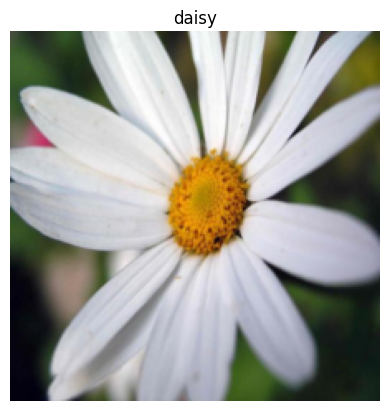

In [52]:
# let's visualize a image in order to know if data is load properly or not

# Get a batch of image
image_batch, label_batch = next(iter(trian_dataloader))

# Get a single image from batch
image, label = image_batch[0], label_batch[0]

# View The batch shapes
print(image.shape, label)

# Plot image with mtplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);


First, let's define the `PatchEmbedding` class, which is responsible for splitting the input image into patches and embedding them.

In [62]:
from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        patch_size: int = 16,
        embed_dim: int = 768,
        img_size: int = 224,
    ):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
        )

        # Corrected: Removed nn.Flatten and will use .flatten() directly in forward
        # self.flattener = nn.Flatten(1, 2)

    def forward(self, x):
        x = self.patcher(x)  # (batch_size, embed_dim, H_out, W_out)
        x = x.flatten(2)     # (batch_size, embed_dim, H_out * W_out)
        x = x.permute(0, 2, 1) # (batch_size, H_out * W_out, embed_dim)
        return x

Next, we define the `MultiHeadAttentionBlock` which performs multi-head self-attention.

In [55]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        num_heads: int = 12,
        attn_dropout: float = 0,
    ):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True,
        )

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x)
        return attn_output

Then, the `MLPBlock` (Multi-Layer Perceptron) for the feed-forward part of the transformer.

In [56]:
class MLPBlock(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        mlp_size: int = 3072,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_size, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

The `TransformerEncoderBlock` combines the multi-head attention and MLP block.

In [57]:
class TransformerEncoderBlock(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        num_heads: int = 12,
        mlp_size: int = 3072,
        attn_dropout: float = 0,
        mlp_dropout: float = 0.1,
    ):
        super().__init__()
        self.msa_block = MultiHeadAttentionBlock(
            embed_dim=embed_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout,
        )
        self.mlp_block = MLPBlock(
            embed_dim=embed_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout,
        )

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

Finally, the full `ViT` (Vision Transformer) model, integrating all components.

In [58]:
import torch

class ViT(nn.Module):
    def __init__(
        self,
        img_size: int = 224,
        in_channels: int = 3,
        patch_size: int = 16,
        num_transformer_layers: int = 12,
        embed_dim: int = 768,
        mlp_size: int = 3072,
        num_heads: int = 12,
        attn_dropout: float = 0,
        mlp_dropout: float = 0.1,
        num_classes: int = 1000,
    ):
        super().__init__()

        self.num_patches = (img_size * img_size) // (patch_size * patch_size)

        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embed_dim=embed_dim,
            img_size=img_size,
        )

        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(
            torch.randn(1, self.num_patches + 1, embed_dim), requires_grad=True
        )

        self.encoder_blocks = nn.Sequential(
            *[TransformerEncoderBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                attn_dropout=attn_dropout,
                mlp_dropout=mlp_dropout,
            ) for _ in range(num_transformer_layers)]
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)
        class_token = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0])
        return x

Now, let's instantiate the ViT model using the previously defined `IMG_SIZE` and `class_names`.

In [63]:
vit_model = ViT(
    img_size=IMG_SIZE,
    num_classes=len(class_names)
).to(device)

print(vit_model)

ViT(
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (encoder_blocks): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TransformerEncoderBlock(
      (msa_block): MultiHeadAttentionBlock(
        (layer_norm): LayerNorm((

In [69]:
from tqdm.auto import tqdm
import torch

def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [70]:
import torch

def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device
):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [71]:
from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device
):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [73]:
# setup the optimizer to optimisee Vit model
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

#setup thre loss function for multi-class
loss_fn = torch.nn.CrossEntropyLoss()

# train the model and save the training result to a dictionary
results = train(model=vit_model,
                train_dataloader=trian_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)
# Save the trained model 's state_dict
torch.save(vit_model.state_dict(),'/content/drive/MyDrive/AI_demo/vit_trained_model.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7506 | train_acc: 0.5000 | test_loss: 1.0022 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.9995 | train_acc: 0.5000 | test_loss: 3.3674 | test_acc: 0.5000
Epoch: 3 | train_loss: 3.3501 | train_acc: 0.5000 | test_loss: 1.1889 | test_acc: 0.5000
Epoch: 4 | train_loss: 1.1846 | train_acc: 0.5000 | test_loss: 1.9315 | test_acc: 0.5000
Epoch: 5 | train_loss: 1.9279 | train_acc: 0.5000 | test_loss: 0.7033 | test_acc: 0.5000
Epoch: 6 | train_loss: 0.7050 | train_acc: 0.5000 | test_loss: 0.7949 | test_acc: 0.5000
Epoch: 7 | train_loss: 0.7892 | train_acc: 0.5000 | test_loss: 1.0444 | test_acc: 0.5000
Epoch: 8 | train_loss: 1.0420 | train_acc: 0.5000 | test_loss: 0.6941 | test_acc: 0.5000
Epoch: 9 | train_loss: 0.6927 | train_acc: 0.5000 | test_loss: 1.1904 | test_acc: 0.5000
Epoch: 10 | train_loss: 1.1892 | train_acc: 0.5000 | test_loss: 0.6941 | test_acc: 0.5000
